# <span style="color:INDIANRED">Training a simple neural network for a 1D second order differential equation</span>

## <span style="color:INDIANRED">  Problem setup</span>
 <div style="color:DARKSLATEGRAY"> 
We want to solve the following ODE for some $f,g_0,g_1$.

\begin{align*}\frac{d^2u}{dx^2}(x) &= f(x), \quad 0 < x < 1, \\
u(0)&=g_0, \\
u(1)&=g_1\end{align*}

We define a trial solution as

$$x(1-x)N_\theta(x)+(1-x)g_0+ xg_1.$$

At first, we define our network $N_\theta$.
</div>

In [1]:
# imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
tf.keras.backend.set_floatx('float64')


In [2]:
# define input placeholder and layers
input_x = Input(shape=(1,), name='x_coordinates')
y1 = Dense(units=10, activation='tanh')(input_x)
y2 = Dense(units=10, activation='tanh')(y1)
output_y = Dense(units=1)(y2)


In [3]:
# let's look at what we have defined
model = Model(input_x,output_y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_coordinates (InputLayer)   (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


## <span style="color:indianred">Specifying boundary condition</span>
<div style="color:DARKSLATEGRAY"> 
Next, we define our trial solution. For this, we need the boundary data. Say we want our solution $u$ to be $$u(x)=\sin(\frac{\pi x}{2})\cos(2\pi x) + 1.$$ We want to define $f$, $g_0$ and $g_1$ accordingly. To avoid computation, we use sympy.</div>


In [4]:
#  define symbolic functions and calculate derivative using sympy
from sympy.abc import x
from sympy import sin, cos, pi, diff

u = sin(pi*x/2)*cos(2*pi*x)+1

f = diff(diff(u, x),x)

In [5]:
f

-17*pi**2*sin(pi*x/2)*cos(2*pi*x)/4 - 2*pi**2*sin(2*pi*x)*cos(pi*x/2)

In [6]:
# convert symbolic function into numpy functions
from sympy import lambdify

u_numpy = lambdify(x, u, 'numpy')
f_numpy = lambdify(x, f, 'numpy')

# define g0 and g1
g0 = u_numpy(0)
g1 = u_numpy(1)

Now we are ready to define our trial solution $$x(1-x)N_\theta(x)+(1-x)g_0+ xg_1.$$

In [7]:
trial_solution = input_x*(1-input_x)*output_y + (1-input_x)*tf.constant(g0) \
                 + input_x*tf.constant(g1)

## <span style="color:indianred"> Define the loss function</span>

In [8]:
# define placeholder for f values
f_placeholder = tf.placeholder(dtype=tf.keras.backend.floatx(),shape=(None,1))

# define gradients
dx = tf.gradients(trial_solution, input_x)[0]
dxdx = tf.gradients(dx, input_x)[0]

# define loss
loss = tf.reduce_mean((dxdx-f_placeholder)**2)

## <span style="color:INDIANRED">Training</span>

We need to choose an optimizer. We use Adam for now. 

In [9]:
opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

Now the only thing we need is training data. We decide to use 100 evenly spaced points in the unit interval.

In [10]:
train_data = np.linspace(0, 1, 100)
train_labels = f_numpy(train_data)
true_solution = u_numpy(train_data)

In [11]:
# just a function for visualization 
from IPython.display import clear_output

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(np.linspace(0,1,len(data)),data, label=label)
    plt.title(title)
    plt.grid(False)
    plt.ylim(0,2.01)
    plt.xlim(0,1)
    plt.xlabel('')
    plt.legend(loc='upper left')
    plt.show()

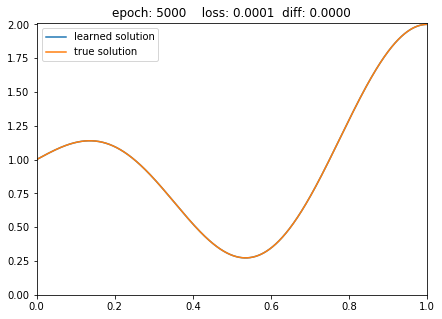

Final loss:5.997481700116845e-05
Final difference:2.541796694267573e-06


In [12]:
# train for some epochs
import time
epochs = 5000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x_values = np.linspace(0,1,1000)
    true_y_values = np.expand_dims(u_numpy(x_values), -1)
    print(sess.run(loss, feed_dict={input_x: np.expand_dims(train_data, -1), f_placeholder: np.expand_dims(train_labels, -1)}))
    for i in range(epochs+1):
        _, out = sess.run([opt, loss], feed_dict={input_x: np.expand_dims(train_data, -1), f_placeholder: np.expand_dims(train_labels, -1)})
        solution_output = sess.run(trial_solution, {input_x: np.expand_dims(x_values, -1)})
        if (epochs < 500) or i%(epochs/100)==0:
            if i < 500:
                time.sleep(0.5)
            live_plot({'learned solution': solution_output, 'true solution': true_y_values}, title='epoch: {}    loss: {:1.4f}  diff: {:1.4f}'.format(i,out, np.mean(np.abs(true_y_values-solution_output))))
print('Final loss:' + str(out))
print('Final difference:' + str(np.mean(np.abs(true_y_values-solution_output))))